# Features Engineering

Our data can be very high dimensional if we consider the number of languages, countries, actors etc. We have only 44k movies, but we have several hundreds on genres, languages and countries, which gives already around 10 millions possibilities. And this is without even looking at the hundreds of thousands of actors and characters. Thus we have to come up with features that can capture signal in the data, without having to do one-hot encoding for each feature.

## Packages

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
# ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
# Sparse Matrix
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz

## Helpers

In [2]:
# These parameters control the formation of the dataframe for regression
# drop: Columns to drop before applying any transform to the data
# nan_filtering: Columns on which we want to remove rows with nans.
#                If 'all', then apply on every one.
# decades: List of decades on which to apply the regression. 
#          If empty list then all decades will be taken.
# log: Columns on which to apply a log transform.
# standardize: Columns to standardize.
# post_drop: Columns to drop before doing the regression.
DEFAULT_PARAMETERS = {
            "drop": ["name","revenue","has_common_character_name","character_number"],
            "nan_filtering":["all"],
            "decades":[],
            "log":[],
            "standardize":["title_length"],
            "post_drop": ["release_date","num_votes",
                            "runtime","decade","average_rating",
                            "combinned_best_rating"]}

SUCCESS_THRESHOLD = 7.5

NE_FULL_LIST = ["ORGANIZATION","PERSON","LOCATION",
                "DATE","TIME","MONEY",
                "PERCENT","FACILITY","GPE"]

EPSILON = 1e-4 # Set to 1e-4 empirically, but idea is to have at least one occurence in all corpus

## Load Data

In [3]:
country_df = pd.read_pickle("../../data/post_processing//country_df.pkl")
comes_from_df = pd.read_pickle("../../data/post_processing/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/post_processing/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/post_processing/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/post_processing/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/post_processing/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/post_processing/character_df.pkl")
actor_df = pd.read_pickle("../../data/post_processing/actor_df.pkl")
movie_df = pd.read_pickle("../../data/post_processing/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/post_processing/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/post_processing/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/post_processing/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")
is_directed_by_df = pd.read_pickle("../../data/post_processing/is_directed_by_df.pkl")
director_df = pd.read_pickle("../../data/post_processing/director_df.pkl")

## Create Regression DataFrame

In [4]:
movie_regression_df = movie_df.copy()
movie_regression_df.drop(["freebase_id","plot"],axis=1,inplace=True)
movie_regression_df["num_votes"] = movie_regression_df["num_votes"].astype(np.int32)

## Actors

For the actors, we thought about the following features:
- #number of actors in the top 5% (or 1% ?)
- #number of actors
- mean actor age
- gender balance

In [5]:
percentile = 99
actor_movie_count = appears_in_df.groupby("actor_id")["movie_id"].count().values
threshold = np.percentile(actor_movie_count,percentile)
is_actor_above_threshold = appears_in_df.groupby("actor_id")["movie_id"].count().sort_index() >= threshold
top_k_actors = actor_df[is_actor_above_threshold.values]
print(f"There are {len(top_k_actors)} actors in the top {percentile}%.")

There are 1014 actors in the top 99%.


In [6]:
actor_movie_df = appears_in_df.merge(actor_df["gender"],how="left",on="actor_id")
actor_movie_df["gender"] = actor_movie_df["gender"].apply(
    lambda g: -1 if g == "M" else 1 if g == "F" else g)
actor_movie_df["is_top_k"] = actor_movie_df["actor_id"].isin(set(top_k_actors.index))

In [7]:
movie_regression_df["actor_number"] = actor_movie_df.groupby("movie_id")["actor_id"].count()
movie_regression_df["mean_actor_age"] = actor_movie_df.groupby("movie_id")["actor_age"].mean()
movie_regression_df["gender_ratio"] = actor_movie_df.groupby("movie_id")["gender"].mean()
movie_regression_df["has_famous_actor"] = actor_movie_df.groupby("movie_id")["is_top_k"].max()
movie_regression_df["has_famous_actor"] = movie_regression_df["has_famous_actor"].replace({True: 1, False: 0})

## Decade

In [8]:
movie_regression_df["decade"] = movie_regression_df["release_date"].apply(lambda d: d.year - d.year%10)

## Gender Ratio

In [9]:
gender_ratio = movie_regression_df.dropna(subset=['gender_ratio', 'decade'])

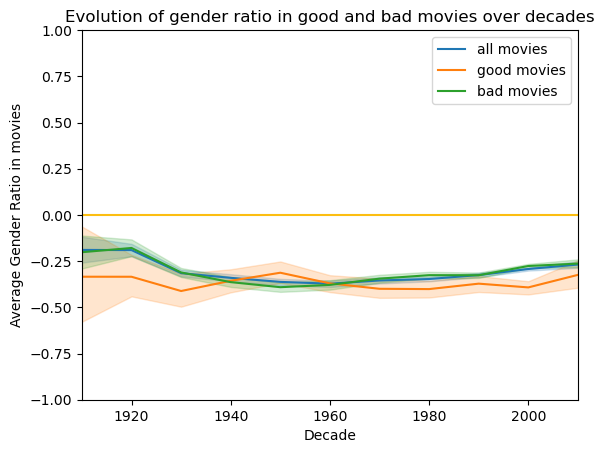

In [10]:
sns.lineplot(data=gender_ratio, x='decade', y='gender_ratio',legend='brief', label='all movies')
sns.lineplot(data=gender_ratio[gender_ratio['average_rating'] > 7.5], x='decade', y='gender_ratio',legend='brief', label='good movies')
sns.lineplot(data=gender_ratio[gender_ratio['average_rating'] < 6.5], x='decade', y='gender_ratio',legend='brief', label='bad movies')
plt.axhline(0, color='#fcbe11')
plt.xlabel('Decade')
plt.ylabel('Average Gender Ratio in movies')
plt.xlim([1910, 2010])
plt.ylim([-1, 1])
plt.title('Evolution of gender ratio in good and bad movies over decades')
plt.legend()
plt.show()